In [30]:
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import general_utils as utils
from NirsLabProject.utils import scalp_spikes_detection
from NirsLabProject.utils import intracranial_spikes_detection
from NirsLabProject.utils import pipeline_utils
from NirsLabProject.utils.sleeping_utils import *
from NirsLabProject.utils import plotting
from NirsLabProject.config.paths import Paths

import scipy.stats as sp_stats
import matplotlib.pyplot as plt
from functools import partial
from scipy.signal import find_peaks
import numpy as np



In [2]:
subject = Subject('p485', bipolar_model=True)

In [3]:
raw = pipeline_utils.resample_and_filter_data(subject)

Reading raw data...
Data for electrode LMH was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LMH1', 'LMH2', 'LMH3', 'LMH4', 'LMH5', 'LMH6', 'LMH7'] channels, 1000.0 Hz
Data for electrode LOF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LOF1', 'LOF2', 'LOF3', 'LOF4', 'LOF5', 'LOF6', 'LOF7'] channels, 1000.0 Hz
Data for electrode RBAA was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RBAA1', 'RBAA2', 'RBAA3', 'RBAA4', 'RBAA5', 'RBAA6', 'RBAA7'] channels, 1000.0 Hz
Data for electrode ROF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['ROF1', 'ROF2', 'ROF3', 'ROF4', 'ROF5', 'ROF6', 'ROF7'] channels, 1000.0 Hz
Data for electrode RPHG was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RPHG1', 'RPHG2', 'RPHG3', 'RPHG4', 'RPHG5', 'RPHG6', 'RPHG7'] chan

In [4]:

    if 'EOG' in raw.keys():
        eog_raw = raw.pop('EOG')
    else:
        eog_raw = None

    # detects intracranial spikes
    intracranial_spikes_spikes_windows = intracranial_spikes_detection.detect_spikes_of_subject(subject, raw)

Detecting Intracranial spikes for subject p485
Spikes already detected for subject p485


In [5]:
raw_electrode = raw['LMH']
channel_name = 'LMH1'
spikes_windows = dict(intracranial_spikes_spikes_windows)

In [60]:
def get_spike_amplitude_and_length(data: np.ndarray, peak_index):
    # taking the spike range (SPIKE_RANGE_SECONDS) before and after the peak timestamp of the window
    spike_range_in_indexes = int(SPIKE_RANGE_SECONDS * SR)
    start_frame_index = max(0, peak_index-spike_range_in_indexes)
    end_frame_index = min(len(data), peak_index+spike_range_in_indexes)

    amplitude = data[peak_index]
    # finding the closest point before the peak with half of the peak amplitude
    first_half_start = start_frame_index + np.where(data[start_frame_index:peak_index] < amplitude / 2)[0]
    if len(first_half_start) > 0:
        first_half_start = first_half_start[-1]
    else:
        # if there is no point before the peak with half of the peak amplitude, we will take the start of the window
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1}

    # finding the closest point after the peak with half of the peak amplitude
    second_half_end = peak_index + np.where(data[peak_index:end_frame_index] < amplitude / 2)[0]
    if len(second_half_end) > 0:
        second_half_end = second_half_end[0]
    else:
        # if there is no point after the peak with half of the peak amplitude, we will take the end of the window
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1}
    
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
    plt.plot(data[start_frame_index:end_frame_index], color='b')
    xp, yp = (spike_range_in_indexes, data[peak_index])
    x1, y1 = (first_half_start-peak_index+spike_range_in_indexes, data[first_half_start])
    delta_x = xp - x1
    delta_y = yp - y1
    slope = (delta_y / delta_x) 
    slope_angle = np.degrees(np.arctan(slope))
#     plt.scatter(xp, yp, color='green', label='Single Point')
#     plt.scatter(x1, y1, color='r', label='Single Point')
#     plt.scatter(x2, y2, color='r', label='Single Point')
#     plt.plot([x1, xp], [y1, yp], linestyle='-', color='orange', label='Line between Points')
    
    # Display the angle as text on the plot
#     plt.text(x1 + 0.5 * delta_x, y1 + 0.5 * delta_y, f'Angle: {angle_deg:.2f} degrees', color='black', fontsize=10)

    return {
        'index': peak_index,
        'amplitude': amplitude,
        'length': second_half_end - first_half_start,
        'angle': slope_angle
    }



def extract_spikes_peaks_features(channel_data: np.ndarray, spikes: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    spikes = np.unique(spikes).flatten()

    if spikes.shape[0] == 0:
        return np.array([]), np.array([])

#     Vectorized feature extraction using np.vectorize
    
    v_extract_features = np.vectorize(partial(get_spike_amplitude_and_length, channel_data))
    
    # Perform feature extraction on all indexes at once
    features_array = v_extract_features(spikes)

#     for i, spike in enumerate(spikes):
#         if i > 4:
#             print(spike)
#             print(get_spike_amplitude_and_length(channel_data, spike))
#         if i > 10:
#             break
#     return [], []
    peaks = np.array([d['amplitude'] for d in features_array])
    lengths = np.array([d['length'] for d in features_array])
    angles = np.array([d['angle'] for d in features_array])

    return peaks, lengths, angles

[33.91309433  3.07364313  8.24076609  0.94866098  2.78296197  2.57039013
  6.79439308  3.32636084  2.41186256  2.7840815   3.42559277  1.71537336
  9.23636985  2.87551137  4.6275633   2.80015843  4.40653082  5.55638423
  2.72649018  2.59986854  3.54638229  5.66055822  3.4600534   6.03553002
 11.55615728  4.89514324  3.97952489  3.66487361  2.20760726  2.16747674
  1.47031771  3.49105236  1.39813387  4.8618592   4.11624284  5.8441456
  4.98989919  4.14668445  6.46504533  6.37055081  1.73924397  8.20877862
  8.75768924  2.50397228  4.68694729  1.21029606  4.91710474  2.22373238
  4.04508576  2.20116675  5.52532364  1.66273339  2.29461111  3.45578643
  5.00550558 10.06828355  3.03029885  5.12206091  2.79279342  2.4407702
  3.52455096  2.71346767  3.60382494  3.26741309  6.38945768  1.25604321
  1.29656136  4.11171225  1.76061068  3.90022599  2.58816007  1.25483705
  3.13291113  7.04997127 32.70198429  3.03718619  2.40343939  4.25727144
  5.09033403 31.86980625  3.09947396  6.21594019  1.7

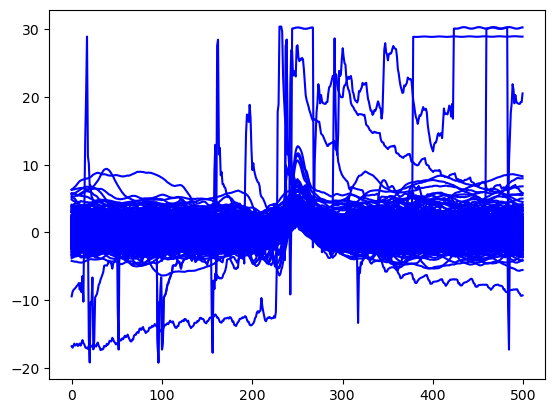

In [61]:

channel_raw = raw_electrode.copy().pick_channels([channel_name])
channel_raw.load_data()
filtered_channel_raw = channel_raw.copy()
filtered_channel_data = channel_raw.get_data()[0]
filtered_channel_data = sp_stats.zscore(filtered_channel_data)
channel_spikes_windows = spikes_windows[channel_name]
channel_spikes_indexes = utils.get_spikes_peak_indexes_in_spikes_windows(filtered_channel_data, channel_spikes_windows)
amplitudes, lengths, angles = extract_spikes_peaks_features(filtered_channel_data, channel_spikes_indexes)
print(angles)